# **Explainable and Knowledge-Guided AI for Chest X-ray Pneumonia Detection**
A Prototype Integrating Deep Learning, Grad-CAM Visual Explanations, and LLM-Based Clinical Reasoning



In [1]:
!pip install torch torchvision matplotlib pandas scikit-learn
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=f77dddbd89d48070fdb848ae21cfd7b659d658cbed231cb3460b13fbbee99f46
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [4]:
!pip install kaggle


In [8]:
!pip install kaggle


In [9]:
import os

os.environ["KAGGLE_API_TOKEN"] = "KGAT_93ff7565feac9b99112d340727d41490"


In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [13]:
!kaggle competitions list | head


ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd       1088           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           200,000 Usd        508           False  
https://www.kaggle.com/competitions/google-tunix-hackathon                          2026-01-12 23:59:00  Featured           100,000 Usd        105           False  
https://www.kaggle.com/competitions/csiro-biomass                                   2026-01-28 23:59:00  Research            75,000 Usd       2822           False  
https://ww

In [14]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(
    "/content/chest_xray/chest_xray/train",
    transform=transform
)

val_data = datasets.ImageFolder(
    "/content/chest_xray/chest_xray/val",
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)

print("Classes:", train_data.classes)



Classes: ['NORMAL', 'PNEUMONIA']


In [19]:
!pip install grad-cam


In [20]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import cv2


In [21]:
target_layers = [model.layer4[-1]]


In [22]:
img_path, label = val_data.samples[0]  # any image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
img_float = img.astype(np.float32) / 255.0


In [26]:
from PIL import Image

img_path, label = val_data.samples[0]

# Load image with OpenCV
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))

# Convert NumPy -> PIL (IMPORTANT LINE)
pil_img = Image.fromarray(img)

# Apply torchvision transform on PIL image
input_tensor = transform(pil_img).unsqueeze(0).to(device)


In [28]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Target layer for ResNet18
target_layers = [model.layer4[-1]]

# Create Grad-CAM object (NO use_cuda)
with GradCAM(model=model, target_layers=target_layers) as cam:

    targets = [ClassifierOutputTarget(1)]  # 1 = PNEUMONIA
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]


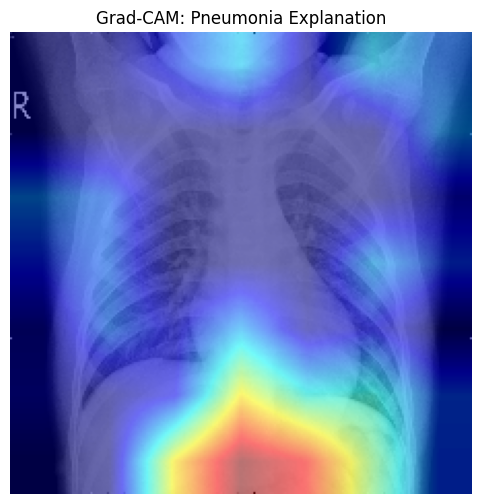

In [29]:
visualization = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,6))
plt.imshow(visualization)
plt.axis('off')
plt.title("Grad-CAM: Pneumonia Explanation")
plt.show()


The Grad-CAM heatmap highlights regions in the lower lung fields that contributed most strongly to the model’s pneumonia prediction.

Clinically, pneumonia is often associated with increased opacity and consolidation in these regions due to inflammation and fluid accumulation within the alveoli. The model’s attention to these areas suggests that its prediction is based on medically meaningful visual patterns rather than spurious features.

This visual explanation provides an initial level of interpretability by showing *where* the model is focusing, forming the foundation for further knowledge-guided reasoning.


## **Knowledge-Guided Clinical Reasoning using Large Language Models**


In [30]:
clinical_knowledge = {
    "pneumonia": {
        "radiological_features": [
            "lung opacity",
            "consolidation",
            "air bronchograms"
        ],
        "clinical_meaning": "Inflammation and fluid accumulation in lung tissue"
    }
}


### LLM Prompt Design



In [31]:
prompt = f"""
A deep learning model predicts Pneumonia from a chest X-ray.
Grad-CAM highlights regions in the lower lung fields.

Known medical knowledge:
{clinical_knowledge['pneumonia']}

Explain step-by-step:
1. What visual features the model focused on
2. How these relate to pneumonia clinically
3. Why this explanation improves trust in AI systems
"""


## **Knowledge-Guided Clinical Reasoning using Large Language Models**

While Grad-CAM highlights the image regions that influence the model’s prediction, it does not explain *why* these regions are clinically meaningful.  
To address this, we incorporate a lightweight Large Language Model (Gemini Flash) to align visual evidence with established medical knowledge.

The goal is not diagnosis automation, but **transparent reasoning** that connects model attention with clinically recognised radiological patterns of pneumonia.


In [36]:
import google.generativeai as genai
from google.colab import userdata

# Get key from Colab Secrets
GEMINI_KEY = userdata.get('GEMINI_KEY')

# Configure Gemini
genai.configure(api_key=GEMINI_KEY)

# Load model
model_llm = genai.GenerativeModel("gemini-2.5-flash")

# Generate response
response = model_llm.generate_content(prompt)

print(response.text)



Here's a step-by-step explanation:

**1. What visual features the model focused on**

The Grad-CAM highlights on the lower lung fields indicate that the model is primarily focusing on **areas within these regions that exhibit characteristics consistent with the provided radiological features of pneumonia.** Specifically, the model is likely detecting:

*   **Increased density or opacity:** Regions that appear whiter or hazier than healthy lung tissue on the X-ray, suggesting fluid or consolidated material.
*   **Consolidation patterns:** More defined areas of increased density, where air sacs (alveoli) are filled with inflammatory exudate, appearing solid on the X-ray.
*   **Potential air bronchograms:** If present within the consolidated areas, these would appear as dark, branching air-filled tubes (bronchi) outlined against the surrounding white consolidated lung tissue.

In essence, the model is *looking for the visual manifestation of disease* in the lower lung fields.

**2. How th

### **Interpreting the LLM-Based Explanation**

The generated explanation connects the highlighted lower lung regions with known radiological manifestations of pneumonia, such as increased opacity, consolidation, and inflammatory exudates.

This step demonstrates how visual explanations can be grounded in domain knowledge, helping bridge the gap between deep learning predictions and clinical interpretation.


*   List item
*   List item



## **Discussion**: Explainability and Trust

This prototype illustrates how Grad-CAM–based visual explanations, when combined with lightweight LLM reasoning, can improve transparency and trust in medical AI systems.

Such knowledge-guided explainability is essential for deploying AI models in high-stakes clinical decision-support settings.
